In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io
from sklearn.decomposition import PCA
import cv2

import os
os.chdir("/Users/xxx/EfficientSAM")

## Visualization Functions

In [2]:
# prompt model
def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

# PCA
def estimate_grasp_direction_from_mask(binary_mask):
    coords = np.argwhere(binary_mask > 0)  # (y, x)
    if coords.shape[0] < 2:
        raise ValueError("Not enough points for PCA")
    coords = coords[:, [1, 0]]  # → (x, y)
    pca = PCA(n_components=2)
    pca.fit(coords)
    angle = np.arctan2(pca.components_[0][1], pca.components_[0][0])
    return angle, pca.mean_, pca.components_


# visualization
def visualize_segmentation_and_pca(img_path, binary_mask, angle, center, components, output_dir, input_points, object_name: str = None):
    image_np = np.array(Image.open(img_path))
    image_np_vis = image_np.copy()
    if image_np_vis.dtype != np.uint8:
        image_np_vis = image_np_vis = cv2.cvtColor(image_np.copy(), cv2.COLOR_RGB2BGR)#(image_np_vis * 255).astype(np.uint8)
    if len(image_np_vis.shape) == 2 or image_np_vis.shape[2] == 1:
        image_np_vis = cv2.cvtColor(image_np_vis, cv2.COLOR_GRAY2BGR)

    # === 0. Draw bounding box overlay ===
    box_overlay = image_np_vis.copy()
    if input_points is not None and input_points.shape == (2, 2):
        (x1, y1), (x2, y2) = input_points
        cv2.rectangle(box_overlay, (x1, y1), (x2, y2), (255, 255, 0), 6) 
        if object_name:
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1.2
            thickness = 3
            label_pos = (x1, y1 - 10 if y1 - 10 > 10 else y1 + 30)
            cv2.putText(box_overlay, object_name, label_pos, font, font_scale, (0, 255, 255), thickness, cv2.LINE_AA)

    # === 1. Overlay segmentation mask ===
    segmentation_overlay = image_np_vis.copy()
    colored_mask = np.zeros_like(segmentation_overlay)
    colored_mask[binary_mask > 0] = [0, 255, 0]  # green overlay
    segmentation_overlay = cv2.addWeighted(segmentation_overlay, 0.7, colored_mask, 0.3, 0)

    # # === 2. Compute object bounding box dimensions ===
    # Step 1: get centered coords (N, 2)
    coords = np.argwhere(binary_mask > 0)[:, [1, 0]]  # (x, y)
    centered = coords - center  # center is PCA mean

    # Step 2: project onto PCA axes
    projected = centered @ components.T  # shape (N, 2)

    # Step 3: measure spread along each axis
    spread_x = projected[:, 0].max() - projected[:, 0].min()
    spread_y = projected[:, 1].max() - projected[:, 1].min()

    # Step 4: set arrow lengths
    x_len = spread_x * 0.5
    y_len = spread_y * 0.5

    # === 3. Draw PCA X/Y frame (ROS style colors) ===
    pca_overlay = image_np_vis.copy()
    center_pt = tuple(map(int, center))

    x_dir = components[0] * x_len
    y_dir = components[1] * y_len

    pt_x_end = tuple(map(int, center + x_dir))  # red → X-axis
    pt_y_end = tuple(map(int, center + y_dir))  # green → Y-axis

    cv2.line(pca_overlay, center_pt, pt_x_end, (255, 0, 0), 10, lineType=cv2.LINE_AA)  # Red (BGR)
    cv2.line(pca_overlay, center_pt, pt_y_end, (0, 255, 0), 10, lineType=cv2.LINE_AA)  # Green (BGR)

    # === 4. Plot ===
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    axes[0].imshow(box_overlay)
    axes[0].set_title("Input Bounding Box")
    axes[0].axis('off')

    axes[1].imshow(segmentation_overlay)
    axes[1].set_title("Segmentation Overlay")
    axes[1].axis('off')

    axes[2].imshow(pca_overlay)
    axes[2].set_title(f"ROS-Style PCA Frame\nRed=X, Green=Y, θ={np.degrees(angle):.2f}°")
    axes[2].axis('off')


    plt.tight_layout()

    # === Save figure ===
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.splitext(os.path.basename(img_path))[0] + "_vis.png"
    save_path = os.path.join(output_dir, filename)
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()   
    plt.close()

    print(f"✅ Saved visualization to {save_path}")

## Load the model

In [3]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits


# Load model
efficient_sam_vitt_model = build_efficient_sam_vitt()
efficient_sam_vitt_model.eval()


/Users/yuzihao/Desktop/ESE-498/EfficientSAM/efficient_sam/efficient_sam.py:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location="cpu")


EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
        )
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )
 

## Set up API Services for Qwen2.5-VL

In [ ]:
import os
from openai import OpenAI
import base64
import cv2 
import json
import time
import base64


def image_to_base64(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

client = OpenAI(
    api_key="sk-xxx_YOUR_API_KEY",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)


SYSTEM_PROMPT = '''
You will receive an instruction intended for a robotic arm. Your task is to extract the starting object and the destination object from the given instruction, identify their respective top-left and bottom-right pixel coordinates within the provided image, and return the data in JSON format. 

For example, if the instruction is: "Where is the object in the table?"
You should return the following JSON structure: 
{
"object": "red block",
"coordinates": [[xmin, ymin, xmax, ymax]],
    }

Ensure that your response contains only the JSON output, without any additional text. 

Instruction:
'''


## Start Testing

In [ ]:
prompt = "Where is the object on the table?"

img_path = "/Users/xxx/cornell_grasp/10/pcd1001r.png"

output_dir = '/Users/xxx/frame_label_outputs'

In [6]:
start_time = time.time()
with open(img_path, "rb") as image_file:
    image_bytes = image_file.read()
    image = base64.b64encode(image_bytes).decode('utf-8')

messages = [
    {"role": "system", "content": [{"type": "text", "text": SYSTEM_PROMPT}]},
    {"role": "user", "content": [
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_to_base64(img_path)}"}},  
    ]},
]

completion = client.chat.completions.create(
    model = "qwen2.5-vl-3b-instruct",
    messages=messages,
)

result = json.loads(completion.choices[0].message.content)
print("API reponse:", completion.choices[0].message.content)

end_time = time.time()

print(f"Total time: {end_time - start_time}")

API reponse: {
"object": "lollipop",
"coordinates": [[187, 332, 360, 409]]
}
Total time: 3.009078025817871


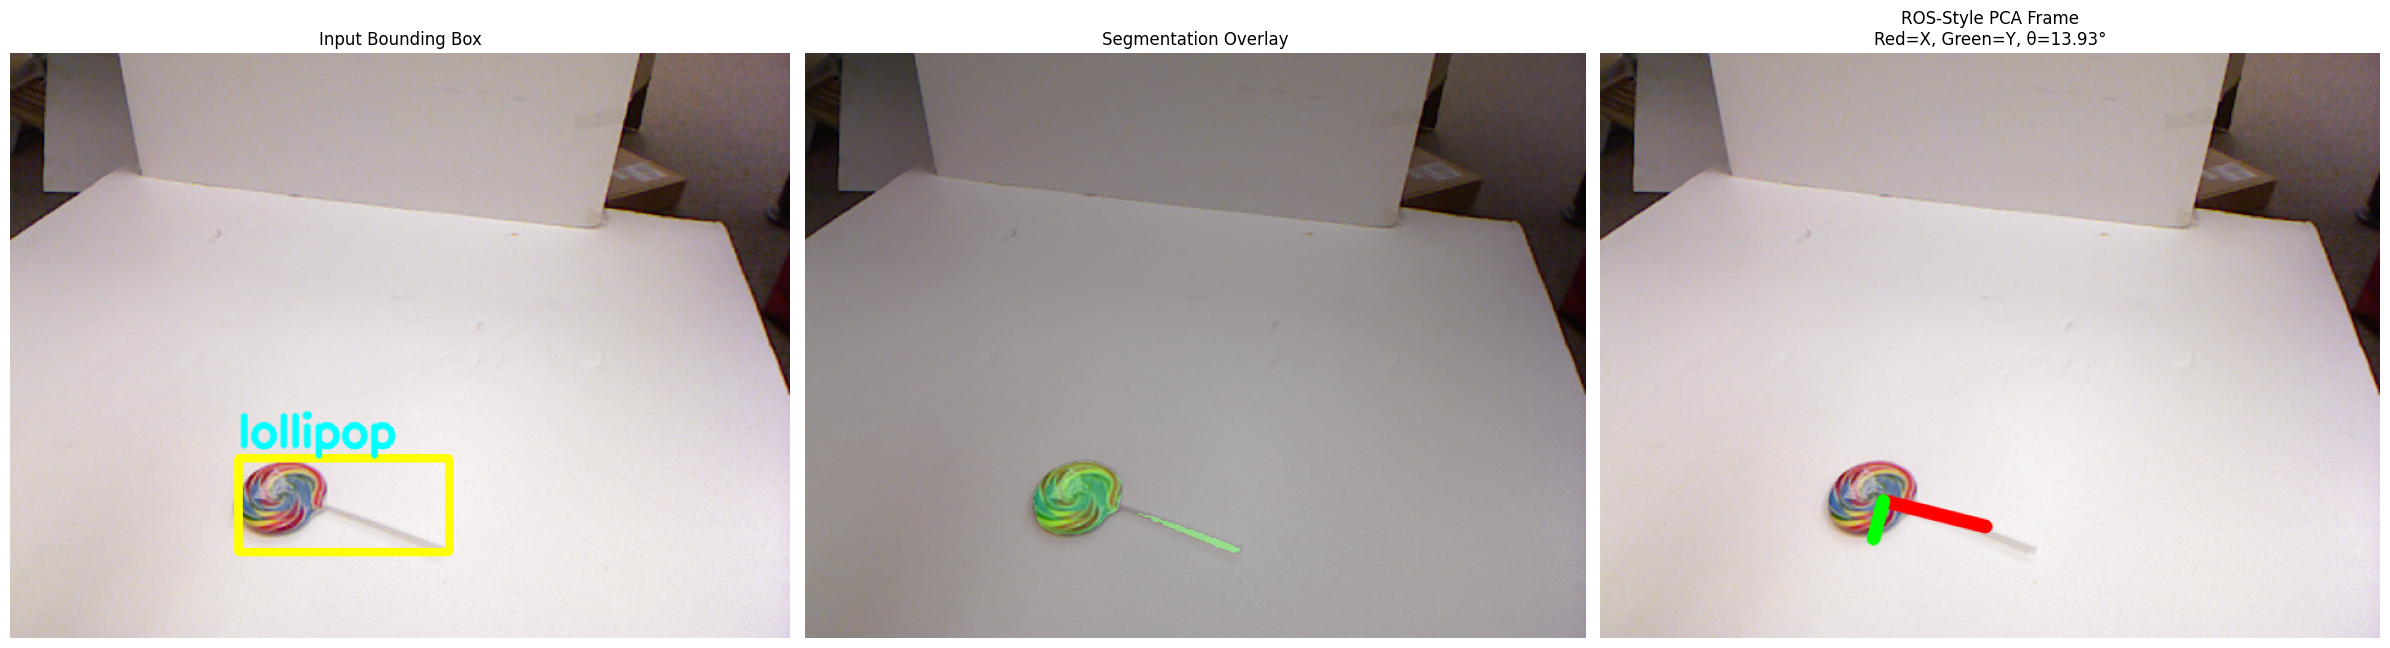

✅ Saved visualization to /Users/yuzihao/Desktop/ESE-498/frame_label_outputs/pcd1001r_vis.png


In [7]:
object_name = result['object']
x1 = result['coordinates'][0][0]
y1 = result['coordinates'][0][1]
x2 = result['coordinates'][0][2]
y2 = result['coordinates'][0][3]

input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])

# Step 1: Get binary mask from EfficientSAM
binary_mask = run_ours_box_or_points(img_path, input_point, input_label, efficient_sam_vitt_model)

# Step 2: Estimate grasp direction from PCA
angle, center, components = estimate_grasp_direction_from_mask(binary_mask)

# Step 3: Visualize direction on original image
visualize_segmentation_and_pca(img_path, binary_mask, angle, center, components, output_dir, input_point, object_name)